# croparray – smoke test notebook


In [1]:
# Environment / imports
import os
from pathlib import Path
import croparray as ca

video_3D_directory = r'../database/Hela'
video_3D_filename = r'Hela_confocal.tif'
csv_filename = r'Crops_Hela_confocal.csv'
crop_array_filename = video_3D_filename[0:-3] + 'nc'
minmass = 100
size = 9

ca1 = ca.open_croparray(os.path.join(video_3D_directory, crop_array_filename))
ca1.best_z_proj(ref_ch=0, disk_r=2, roll_n=3);

In [ ]:
# ca1.ops.apply(
#     ca.tools.spot_detect_and_qc,
#     channels=[0],
#     source="best_z",
#     out_name="ch{ch}_spots",
#     func_kwargs={"minmass": minmass, "size": size},
#     compute_sum_xy=True,
#     sum_name="{out}_sig",
# );

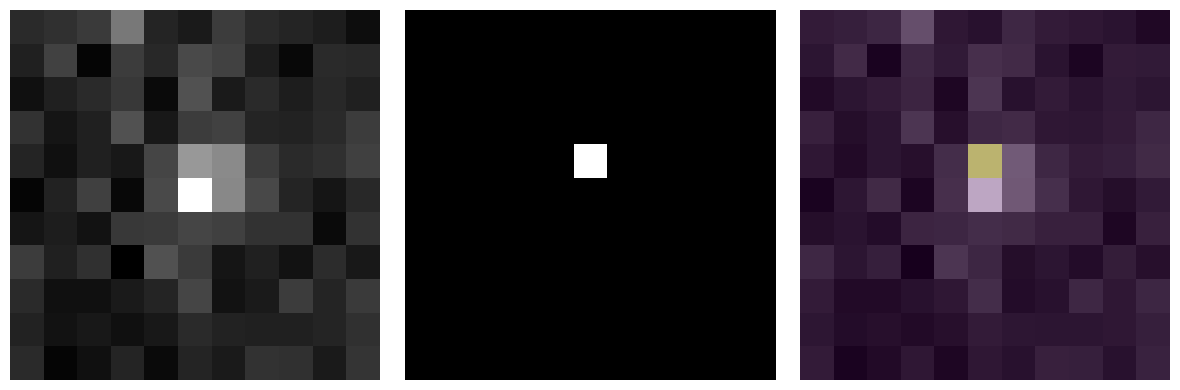

In [24]:
import matplotlib.pyplot as plt
# Pick one representative crop (adjust indices)
da0 = ca1.ds["best_z"].sel(ch=0)  # if ch exists; otherwise omit .sel(ch=0)
da = da0.isel(fov=0, n=25, t=0)
img = da.values
mask = ca.tools.binarize_crop(img,minmass=minmass,size=size,smooth_sigma=1.0,subtract_bg="gaussian",bg_sigma=12.0,bg_mode="border",clip_percentiles=(1, 99.5),snr_low=2.0,snr_high=8.0,gamma_strict=.99,gamma_loose=0.30,min_snr_to_segment=5,k_bg=7,use_watershed=True,compactness=0.0,return_uint8=False,)
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(mask, cmap="gray")
plt.axis("off")
plt.subplot(1, 3, 3)
plt.imshow(img, cmap="gray")
plt.imshow(mask, alpha=0.35)
plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
ca1.ops.apply(
    ca.tools.binarize_crop,
    channels=[0], source="best_z", out_name="ch{ch}_mask",
    func_kwargs=dict(minmass=minmass, size=size, smooth_sigma=1.0,
                     subtract_bg="gaussian", bg_sigma=12.0, bg_mode="border",
                     clip_percentiles=(1, 99.5), snr_low=2.0, snr_high=8.0,
                     gamma_strict=0.99, gamma_loose=0.55, min_snr_to_segment=1.5,
                     k_bg=4, use_watershed=True, compactness=2.5,
                     return_uint8=True),
    compute_sum_xy=True, sum_name="{out}_area_px",
);


In [41]:
my_ta = ca.tools.track_array(ca1);

In [42]:
import napari
# open napari viewer
viewer = napari.Viewer()
temp = ca.tools.montage(my_ta, row = 'track_id', col = 't').best_z
temp_ch0 = ca.tools.montage(my_ta, row = 'track_id', col = 't').ch0_mask #.ch0_spots

# temp_ch1 = ca.tools.montage(my_ta, row = 'track_id', col = 't').ch1_spots
# temp_ch2 = ca.tools.montage(my_ta, row = 'track_id', col = 't').ch2_spots
# view the action of montage
viewer.add_image(temp.sel(ch=0), colormap='red', name='mRNA', blending='additive', contrast_limits=[0,temp.sel(ch=0).fillna(0).data.max()])
viewer.add_image(temp.sel(ch=1), colormap='green', name='mScar3', blending='additive', contrast_limits=[0,temp.sel(ch=1).fillna(0).data.max()])
viewer.add_image(temp.sel(ch=2), colormap='blue', name='mStayG', blending='additive', contrast_limits=[0,temp.sel(ch=2).fillna(0).data.max()])
viewer.add_image(temp_ch0, colormap='yellow', name='ch_spots', blending='additive', contrast_limits=[0,temp_ch0.data.max()])

<Image layer 'ch_spots' at 0x79416fac3c40>

In [1]:
# Environment / imports
import os
from pathlib import Path

import numpy as np
import pandas as pd
from skimage.io import imread
# To make plots
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import seaborn as sns

plt.style.use('dark_background')

# IMPORTANT: import from the package (not by chdir hacks)
from croparray.crop_array_tools import create_crop_array

print("Working directory:", os.getcwd())

Working directory: /home/tstasevi/projects/croparray/notebooks


In [2]:
# Enter in the following:
video_3D_directory = r'../database/Hela'
video_3D_filename = r'Hela_confocal.tif'
csv_filename = r'Crops_Hela_confocal.csv'
crop_array_filename = video_3D_filename[0:-3] + 'nc'

video_path = Path(video_3D_directory) / video_3D_filename
csv_path = Path(video_3D_directory) / csv_filename

print("Video:", video_path.resolve())
print("CSV:  ", csv_path.resolve())
print("Output nc name:", crop_array_filename)

assert video_path.exists(), f"Missing video file: {video_path}"
assert csv_path.exists(), f"Missing CSV file: {csv_path}"


Video: /home/tstasevi/projects/croparray/database/Hela/Hela_confocal.tif
CSV:   /home/tstasevi/projects/croparray/database/Hela/Crops_Hela_confocal.csv
Output nc name: Hela_confocal.nc


In [3]:
# Load the test data
# dimensions MUST be (fov, f = frame, z, y, x, ch)
video = np.array([imread(os.path.join(video_3D_directory,video_3D_filename))])
# Read in csv; note minimal need columns to be used for fov = field of view, f = frame, id = crop/track id #, yc = y-center position of crop, xc - x-center position of crop
df = pd.read_csv(os.path.join(video_3D_directory, csv_filename)) 
# Rename the Trackmate columns to crop array standards of fov, f, id, yc, and xc
df.rename(columns={'POSITION_X': 'xc','POSITION_Y': 'yc', 'FRAME': 'f','TRACK_ID':'id'}, inplace=True, errors='raise')
 # Here we need to create an fov column since there was only 1 fov with the sample dataset. Can give it a name, but note that in the crop array it will be assigned a unique fov integer number starting from 0
df['fov']=video_3D_filename  
# can include other optional columns for making layers, like 'ID', and 'MEAN_INTENSITY'
df = df[['fov','id','f','yc','xc','ID','MEAN_INTENSITY']]  
video.shape,df.head()

((1, 33, 7, 472, 312, 3),
                  fov  id  f    yc    xc     ID  MEAN_INTENSITY
 0  Hela_confocal.tif   0  0  14.0  69.0  10777        1097.358
 1  Hela_confocal.tif   0  1  13.0  69.0  11306        1135.689
 2  Hela_confocal.tif   0  2  14.0  69.0  11135        1129.935
 3  Hela_confocal.tif   0  3  14.0  69.0  10954        1129.091
 4  Hela_confocal.tif   0  4  13.0  70.0  11466        1120.109)

In [4]:
# Build crop array object (CropArray wrapper)
# Adjust kwargs (xy_pad, z_pad, etc.) to match your CSV/video conventions if needed.
ca1 = create_crop_array(video, df)
ca1


Original video dimensions:  (1, 33, 7, 472, 312, 3)
Padded video dimensions:  (1, 33, 7, 484, 324, 3)
Max # of spots per frame:  104
Shape of numpy array to hold all crop intensity data:  (1, 104, 33, 7, 11, 11, 3)
Shape of xc and yc numpy arrays:  (1, 104, 33, 3)
Shape of extra my_layers numpy array:  (3, 1, 104, 33)


CropArray(ds=<xarray.Dataset> Size: 70MB
Dimensions:         (fov: 1, n: 104, t: 33, z: 7, y: 11, x: 11, ch: 3)
Coordinates:
  * fov             (fov) int64 8B 0
  * n               (n) int16 208B 0 1 2 3 4 5 6 7 ... 97 98 99 100 101 102 103
  * t               (t) int64 264B 0 1 2 3 4 5 6 7 8 ... 25 26 27 28 29 30 31 32
  * z               (z) int64 56B 0 1 2 3 4 5 6
  * y               (y) int64 88B -5 -4 -3 -2 -1 0 1 2 3 4 5
  * x               (x) int64 88B -5 -4 -3 -2 -1 0 1 2 3 4 5
  * ch              (ch) int64 24B 0 1 2
Data variables:
    int             (fov, n, t, z, y, x, ch) int64 70MB 23 17 37 21 ... 0 0 0 0
    xc              (fov, n, t, ch) int64 82kB 75 75 75 75 75 75 ... 0 0 0 0 0 0
    yc              (fov, n, t, ch) int64 82kB 20 20 20 19 19 19 ... 0 0 0 0 0 0
    dx              int64 8B 1
    dy              int64 8B 1
    dz              int64 8B 1
    dt              int64 8B 1
    xy_pad          int64 8B 5
    id              (fov, n, t) float64 27kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ID              (fov, n, t) float64 27kB 1.078e+04 1.131e+04 ... 0.0 0.0
    MEAN_INTENSITY  (fov, n, t) float64 27kB 1.097e+03 1.136e+03 ... 0.0 0.0
Attributes:
    name:     video_filename
    date:     video_date)

In [5]:
my_ta = ca1.to_trackarray(channel_to_track=0, min_track_length=5, search_range=10, memory=1)
my_ta


Frame 32: 75 trajectories present.


TrackArray(tracks=120, t=33)

In [6]:
# Test method: best_z_proj
# Common args in your codebase: ref_ch, disk_r, roll_n
# If your dataset doesn't have 'ch' dimension, set ref_ch appropriately or omit.
ca1.best_z_proj(ref_ch=0, disk_r=2, roll_n=3)

ca1

CropArray(ds=<xarray.Dataset> Size: 80MB
Dimensions:         (fov: 1, n: 104, t: 33, z: 7, y: 11, x: 11, ch: 3)
Coordinates:
  * fov             (fov) int64 8B 0
  * n               (n) int16 208B 0 1 2 3 4 5 6 7 ... 97 98 99 100 101 102 103
  * t               (t) int64 264B 0 1 2 3 4 5 6 7 8 ... 25 26 27 28 29 30 31 32
  * z               (z) int64 56B 0 1 2 3 4 5 6
  * y               (y) int64 88B -5 -4 -3 -2 -1 0 1 2 3 4 5
  * x               (x) int64 88B -5 -4 -3 -2 -1 0 1 2 3 4 5
  * ch              (ch) int64 24B 0 1 2
Data variables: (12/14)
    int             (fov, n, t, z, y, x, ch) int64 70MB 23 17 37 21 ... 0 0 0 0
    xc              (fov, n, t, ch) int64 82kB 75 75 75 75 75 75 ... 0 0 0 0 0 0
    yc              (fov, n, t, ch) int64 82kB 20 20 20 19 19 19 ... 0 0 0 0 0 0
    dx              int64 8B 1
    dy              int64 8B 1
    dz              int64 8B 1
    ...              ...
    id              (fov, n, t) int64 27kB 1 1 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0
    ID              (fov, n, t) float64 27kB 1.078e+04 1.131e+04 ... 0.0 0.0
    MEAN_INTENSITY  (fov, n, t) float64 27kB 1.097e+03 1.136e+03 ... 0.0 0.0
    spot_id         (fov, n, t) float64 27kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    zc              (fov, n, t) int64 27kB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    best_z          (ch, fov, n, t, y, x) float64 10MB 23.0 26.0 ... 0.0 0.0
Attributes:
    name:     video_filename
    date:     video_date)

In [7]:
# Test method: measure_signal (updates ca1.ds in place and returns self for chaining)
ca1 = ca1.measure_signal(ref_ch=0, disk_r=2, disk_bg=7)

ca1


CropArray(ds=<xarray.Dataset> Size: 80MB
Dimensions:         (fov: 1, n: 104, t: 33, z: 7, y: 11, x: 11, ch: 3)
Coordinates:
  * fov             (fov) int64 8B 0
  * n               (n) int16 208B 0 1 2 3 4 5 6 7 ... 97 98 99 100 101 102 103
  * t               (t) int64 264B 0 1 2 3 4 5 6 7 8 ... 25 26 27 28 29 30 31 32
  * z               (z) int64 56B 0 1 2 3 4 5 6
  * y               (y) int64 88B -5 -4 -3 -2 -1 0 1 2 3 4 5
  * x               (x) int64 88B -5 -4 -3 -2 -1 0 1 2 3 4 5
  * ch              (ch) int64 24B 0 1 2
Data variables: (12/15)
    int             (fov, n, t, z, y, x, ch) int64 70MB 23 17 37 21 ... 0 0 0 0
    xc              (fov, n, t, ch) int64 82kB 75 75 75 75 75 75 ... 0 0 0 0 0 0
    yc              (fov, n, t, ch) int64 82kB 20 20 20 19 19 19 ... 0 0 0 0 0 0
    dx              int64 8B 1
    dy              int64 8B 1
    dz              int64 8B 1
    ...              ...
    ID              (fov, n, t) float64 27kB 1.078e+04 1.131e+04 ... 0.0 0.0
    MEAN_INTENSITY  (fov, n, t) float64 27kB 1.097e+03 1.136e+03 ... 0.0 0.0
    spot_id         (fov, n, t) float64 27kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    zc              (fov, n, t) int64 27kB 0 0 0 1 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    best_z          (ch, fov, n, t, y, x) float64 10MB 1.0 -1.0 13.0 ... 0.0 0.0
    signal          (ch, fov, n, t) float64 82kB 22.0 32.54 20.96 ... 0.0 0.0
Attributes:
    name:     video_filename
    date:     video_date)

In [8]:
from croparray.crop_array_tools import open_croparray

test = open_croparray(os.path.join(video_3D_directory, crop_array_filename))
test.best_z_proj(ref_ch=0, disk_r=2, roll_n=3)
test



CropArray(ds=<xarray.Dataset> Size: 45MB
Dimensions:         (n: 104, t: 33, y: 11, x: 11, z: 7, ch: 3, fov: 1)
Coordinates:
  * n               (n) int16 208B 0 1 2 3 4 5 6 7 ... 97 98 99 100 101 102 103
  * t               (t) int32 132B 0 1 2 3 4 5 6 7 8 ... 25 26 27 28 29 30 31 32
  * y               (y) int32 44B -650 -520 -390 -260 -130 0 130 260 390 520 650
  * x               (x) int32 44B -650 -520 -390 -260 -130 0 130 260 390 520 650
  * z               (z) int32 28B 0 500 1000 1500 2000 2500 3000
  * ch              (ch) int32 12B 0 1 2
  * fov             (fov) int32 4B 0
Data variables: (12/13)
    int             (fov, n, t, z, y, x, ch) int32 35MB ...
    xc              (fov, n, t, ch) int32 41kB ...
    yc              (fov, n, t, ch) int32 41kB ...
    id              (fov, n, t) float64 27kB ...
    ID              (fov, n, t) float64 27kB ...
    MEAN_INTENSITY  (fov, n, t) float64 27kB ...
    ...              ...
    dy              int32 4B ...
    dz              int32 4B ...
    dt              int32 4B ...
    xy_pad          int32 4B ...
    zc              (fov, n, t) int64 27kB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    best_z          (ch, fov, n, t, y, x) float64 10MB 23.0 26.0 ... 0.0 0.0
Attributes:
    name:     ../database/Hela/Hela_confocal.tif
    date:     2021-12-25
    notes:    A crop array with ch0 = MYH9 mRNA, ch1 = nascent myo2A peptide ...
    units:    nm and s)

In [9]:
test.to_netcdf(os.path.join(video_3D_directory, crop_array_filename))

In [10]:
test2 = open_croparray(os.path.join(video_3D_directory, crop_array_filename))
test2

CropArray(ds=<xarray.Dataset> Size: 45MB
Dimensions:         (n: 104, t: 33, y: 11, x: 11, z: 7, ch: 3, fov: 1)
Coordinates:
  * n               (n) int16 208B 0 1 2 3 4 5 6 7 ... 97 98 99 100 101 102 103
  * t               (t) int32 132B 0 1 2 3 4 5 6 7 8 ... 25 26 27 28 29 30 31 32
  * y               (y) int32 44B -650 -520 -390 -260 -130 0 130 260 390 520 650
  * x               (x) int32 44B -650 -520 -390 -260 -130 0 130 260 390 520 650
  * z               (z) int32 28B 0 500 1000 1500 2000 2500 3000
  * ch              (ch) int32 12B 0 1 2
  * fov             (fov) int32 4B 0
Data variables: (12/13)
    best_z          (ch, fov, n, t, y, x) float64 10MB ...
    int             (fov, n, t, z, y, x, ch) int32 35MB ...
    xc              (fov, n, t, ch) int32 41kB ...
    yc              (fov, n, t, ch) int32 41kB ...
    id              (fov, n, t) float64 27kB ...
    ID              (fov, n, t) float64 27kB ...
    ...              ...
    zc              (fov, n, t) int32 14kB ...
    dx              int32 4B ...
    dy              int32 4B ...
    dz              int32 4B ...
    dt              int32 4B ...
    xy_pad          int32 4B ...
Attributes:
    name:     ../database/Hela/Hela_confocal.tif
    date:     2021-12-25
    notes:    A crop array with ch0 = MYH9 mRNA, ch1 = nascent myo2A peptide ...
    units:    nm and s)

In [15]:
test2.measure_signal(ref_ch=0, disk_r=2, disk_bg=7)
test2

CropArray(ds=<xarray.Dataset> Size: 45MB
Dimensions:         (n: 104, t: 33, y: 11, x: 11, z: 7, ch: 3, fov: 1)
Coordinates:
  * n               (n) int16 208B 0 1 2 3 4 5 6 7 ... 97 98 99 100 101 102 103
  * t               (t) int32 132B 0 1 2 3 4 5 6 7 8 ... 25 26 27 28 29 30 31 32
  * y               (y) int32 44B -650 -520 -390 -260 -130 0 130 260 390 520 650
  * x               (x) int32 44B -650 -520 -390 -260 -130 0 130 260 390 520 650
  * z               (z) int32 28B 0 500 1000 1500 2000 2500 3000
  * ch              (ch) int32 12B 0 1 2
  * fov             (fov) int32 4B 0
Data variables: (12/14)
    best_z          (ch, fov, n, t, y, x) float64 10MB 1.0 -1.0 13.0 ... 0.0 0.0
    int             (fov, n, t, z, y, x, ch) int32 35MB ...
    xc              (fov, n, t, ch) int32 41kB ...
    yc              (fov, n, t, ch) int32 41kB ...
    id              (fov, n, t) float64 27kB ...
    ID              (fov, n, t) float64 27kB ...
    ...              ...
    dx              int32 4B 130
    dy              int32 4B ...
    dz              int32 4B ...
    dt              int32 4B ...
    xy_pad          int32 4B ...
    signal          (ch, fov, n, t) float64 82kB 22.0 32.54 20.96 ... 0.0 0.0
Attributes:
    name:     ../database/Hela/Hela_confocal.tif
    date:     2021-12-25
    notes:    A crop array with ch0 = MYH9 mRNA, ch1 = nascent myo2A peptide ...
    units:    nm and s)

In [16]:
test2.to_netcdf(os.path.join(video_3D_directory, crop_array_filename))

In [17]:
test3 = open_croparray(os.path.join(video_3D_directory, crop_array_filename))
test3

CropArray(ds=<xarray.Dataset> Size: 45MB
Dimensions:         (n: 104, t: 33, y: 11, x: 11, z: 7, ch: 3, fov: 1)
Coordinates:
  * n               (n) int16 208B 0 1 2 3 4 5 6 7 ... 97 98 99 100 101 102 103
  * t               (t) int32 132B 0 1 2 3 4 5 6 7 8 ... 25 26 27 28 29 30 31 32
  * y               (y) int32 44B -650 -520 -390 -260 -130 0 130 260 390 520 650
  * x               (x) int32 44B -650 -520 -390 -260 -130 0 130 260 390 520 650
  * z               (z) int32 28B 0 500 1000 1500 2000 2500 3000
  * ch              (ch) int32 12B 0 1 2
  * fov             (fov) int32 4B 0
Data variables: (12/14)
    best_z          (ch, fov, n, t, y, x) float64 10MB ...
    signal          (ch, fov, n, t) float64 82kB ...
    int             (fov, n, t, z, y, x, ch) int32 35MB ...
    xc              (fov, n, t, ch) int32 41kB ...
    yc              (fov, n, t, ch) int32 41kB ...
    id              (fov, n, t) float64 27kB ...
    ...              ...
    zc              (fov, n, t) int32 14kB ...
    dx              int32 4B ...
    dy              int32 4B ...
    dz              int32 4B ...
    dt              int32 4B ...
    xy_pad          int32 4B ...
Attributes:
    name:     ../database/Hela/Hela_confocal.tif
    date:     2021-12-25
    notes:    A crop array with ch0 = MYH9 mRNA, ch1 = nascent myo2A peptide ...
    units:    nm and s)